# 평가
성능 평가 지표(Evaluation Metric)은 모델이 분류냐 회귀냐에 따라 여러 종류로 나뉜다.
* `회귀` : 실제값과 예측값의 오차 평균값에 기반
* `분류` : 실제 결과값과 예측 결과값이 얼마나 정확한지에 기반하지만 다른 평가 지표도 활용
    * 정확도(Accuracy) / 오차행렬(Confusion Matrix) / 정밀도(Precision) / 재현율(Recall) / F1 스코어 / ROC AUC
    * 이진 분류(0 or 1)과 멀티 분류(여러 개의 값) 둘 다 적용되지만 이진 분류에서 더욱 중요시됨

## 1. 정확도(Accuracy)

$$정확도(Accuracy) = \frac{예측 결과가 동일한 데이터 건수}{전체 예측 데이터 건수}$$

정확도는 직관적으로 모델 예측 성능을 나타내지만, 이진 분류에서 데이터의 구성에 따라 **성능을 왜곡**할 수도 있다. 

### 1.1. 타이타닉 생존자 데이터 세트

In [35]:
from sklearn import preprocessing
import numpy as np

In [36]:
# Null값 처리
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    return df

In [37]:
# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    
    return df

In [38]:
from sklearn.base import BaseEstimator     # 커스텀 가능한 Estimator

# 아무런 학습을 하지 않고 성별에 따라 생존자를 예측
class MyDummyClassifier(BaseEstimator):
    # fit() : 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    
    # predict() : Sex가 1이면 0(사망), 0이면 1(생존)으로 예측
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        
        return pred

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df = pd.read_csv('./train.csv')             # 데이터 로딩
y_titanic_df = titanic_df['Survived']               # 레이블 데이터 세트
X_titanic_df = titanic_df.drop('Survived', axis=1)  # 피처 데이터 세트
X_titanic_df = transform_features(X_titanic_df)     # 데이터 전처리

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)     # 학습

mypred = myclf.predict(X_test)  # 예측
print('Dummy Classifier의 정확도 : {0:.4f}'.format(accuracy_score(y_test, mypred)))    # 평가

Dummy Classifier의 정확도 : 0.7877


타이타닉 생존자 예측의 정확도는 약 80% 였는데, 단순히 성별을 가지고 생존자 예측했을 대의 정확도는 약 78%로 꽤 높은 수치가 나왔다.      

정확도의 경우 **불균형한 레이블 값 분포**에서 적합한 평가 지표가 되기 어렵다. 예를 들어 100개의 데이터가 있고 이 중 90개의 데이터의 레이블이 0이고 10개가 1일 경우, **무조건 0을 반환하는 단순한 모델**조차 정확도가 90%가 나온다.

### 1.2. MNIST 데이터셋
0부터 9까지의 숫자 이미지 픽셀 정보를 가지고 있으며, 이 정보를 바탕으로 숫자 Digit을 예측한다. 

이것의 레이블 값을 7인 것만 `True`, 나머지 값은 모두 `False`를 반환하는 **이진 분류 문제**로 살짝 바꾸어보자. 이럴 경우 `10%`만 `True`이고 `90%`가 `False`인 **불균형한 데이터 세트**로 변형된다.

In [40]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

In [41]:
class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력으로 들어오는 X 데이터 세트의 크기만큼 모두 0으로 만들어 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [42]:
# MNIST 데이터 로딩
digits = load_digits()

# 7이면 True(1), 아니면 False(0)을 반환
y = (digits.target == 7).astype(int)     # True -> 1, False -> 0
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 : ', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도 : ')
print(pd.Series(y_test).value_counts())

레이블 테스트 세트 크기 :  (450,)
테스트 세트 레이블 0과 1의 분포도 : 
0    405
1     45
dtype: int64


In [44]:
# MyFakeClassifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)

print('모든 예측을 0으로 해도 정확도는 {0:.4f} 이다.'.format(accuracy_score(y_test, fakepred)))

모든 예측을 0으로 해도 정확도는 0.9000 이다.


### 1.3. 결론
불균형한 레이블 데이터 세트에서는 정확도를 평가 지표로 사용해서는 안된다.

## 2. 오차 행렬
오차 행렬(confusion matrix)은 학습된 분류 모델이 예측을 수행하면서 **얼마나 헷갈리고(confused) 있는지**도 같이 보여주는 지표이다. 즉, **이진 분류의 예측 오류가 얼마나 났는지**와 **어떤 유형의 예측 오류가 났는지**를 보여준다.
* `TN` : **Negative**라고 예측했는데 실제 **Negative**인 경우
* `FN` : **Negative**라고 예측했는데 실제 **Postivie**인 경우
* `FP` : **Positive**라고 예측했는데 실제 **Negative**인 경우
* `TP` : **Positive**라고 예측했는데 실제 **Positive**인 경우

<img src='confusion_mat.png' alt="오차 행렬" width=70%>

`confusion_matrix(y_true, y_pred)`로 오차행렬을 구할 수 있다.
* `y_true` : 테스트 라벨 데이터
* `y_pred` : 예측한 라벨 데이터

### 2.1. `MyFakeClassifier`의 오차행렬 계산

In [45]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

`MyFakeClassifier`는 **숫자가 7이면 `True`, 아니면 `False`인 라벨 데이터 세트**에서 **무조건 `False`로 분류**하는 분류기이다.    
그러므로 무조건 7이 아니라고 예측 (**Negative**) 하므로 (**Positive**)에 해당하는 데이터는 0이 된다.
* `TN` : 7이 아니라고 예측했는데 실제로 아닌 경우 (405)
* `FP` : 7이라고 예측했는데 실제로 7이 아닌 경우 (0)
* `FN` : 7이 아니라고 예측했는데 실제로 7인 경우 (45)
* `TP` : 7이라고 예측했는데 실제로 7인 경우 (0)

### 2.2. 정확도 (Accuracy)
$$정확도(Accuracy) = \frac{TN+TP}{TN+FP+FN+TP}$$

일반적으로 이진 분류 클래스에서는 중점적으로 찾아야 하는 매우 적은 수의 결과값에 **Positive**를, 그렇지 않은 결과값에 **Negative**를 부여한다. 
* 사기 행위를 **Positive**, 정상 행위를 **Negative**
* 암이 양성인 경우 **Positive**, 음성인 경우 **Negative**

이런 경우 레이블 데이터가 불균형한데 **Positive한 데이터 수가 매우 작기** 때문에 데이터에 기반한 ML 알고리즘은 **Positive보다는 Negative로 예측하는 경향이 더 강해지게** 된다.   
그러면 **`TN`은 매우 커지고 `TP`는 매우 작아지게** 되고 Negative로 예측할 때 정확도가 높고 Positive로 예측하는 경향이 낮기 때문에 **`FN`은 매우 작아지고 `FP`도 매우 작아지게** 된다.

결국에는 Positive한 데이터 수가 매우 작고 Negative한 데이터수가 매우 크기 때문에 **Positive한 예측 정확도를 판단한지 못하고 Negative에 대한 예측 정확도만으로도 분류 정확도가 매우 높게 나타**나는 오류를 일으키게 된다.

## 3. 정밀도와 재현율
정밀도와 재현율은 **Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표**이다.

* 정밀도(Precision) : **예측을 Positive로 한 대상** 중에서 예측과 실제 값이 Positive로 일치한 데이터의 비율 (= 양성예측)
$$정밀도(Precision) = \frac{TP}{FP+TP}$$
* 재현율(Recall) : **실제 값이 Positive인 대상** 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율(= 민감도, TPR)
$$재현율(Recall) = \frac{TP}{FN+TP}$$



### 3.1. 예시
#### 3.1.1. 재현율이 중요한 경우
실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 큰 영향이 발생하는 경우
* 실제 암 환자(Positive)를 암이 아니라고 예측(Negative)하는 경우
* 실제 보험 사기(Positive)를 보험 사기가 아니라고 예측(Negative)하는 경우

#### 3.1.2. 정밀도가 중요한 경우
실제 Negative 음성 데이터를 Positive로 잘못 판단하게 되면 큰 영향이 발생하는 경우
* 실제 일반 메일(Negative)를 스팸 메일이라고 예측(Positive)하는 경우

#### 3.1.3 결론
재현율(Recall)은 FN(실제 Positive, 예측 Negative)을, 정밀도(Precision)는 FP(실제 Negative, 예측 Positive)를 낮추는데 초점을 맞춘다. 그래서 재현율과 정밀도는 상호보완적이며 가장 좋은 성능 평가는 **정밀도와 재현율이 모두 높은 것**을 말한다.

### 3.2. `precision_score()`와 `recall_score()`
정밀도(Precision) 계산시 `precision_score()`를, 재현율(Recall) 계산시 `recall_score()`를 사용하면 된다.

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 정확도(Accuracy), 정밀도(Precision), 재현율(Recall), 오차행렬(Confusion Matrix)를 구하는 함수
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    print('오차 행렬 : ')
    print(confusion)
    print('정확도(Accuracy) : {0:.4f}, 정밀도(Precision) : {1:.4f}, 재현율(Recall) : {2:.4f}, '.format(accuracy, precision, recall))

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('./train.csv')     # 데이터 로딩
y_titanic_df = titanic_df['Survived']       # 레이블 데이터 세트
X_titanic_df = titanic_df.drop('Survived', axis=1)     # 피처 데이터 세트
X_titanic_df = transform_features(X_titanic_df)

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

# 로지스틱 회귀 모델
lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)     # 학습
pred = lr_clf.predict(X_test)    # 예측
get_clf_eval(y_test, pred)

오차 행렬 : 
[[108  10]
 [ 14  47]]
정확도(Accuracy) : 0.8659, 정밀도(Precision) : 0.8246, 재현율(Recall) : 0.7705, 


C:\Users\round\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### 3.3. 정밀도/재현율 Trade-off
정밀도나 재현율이 강조되어야 할 경우 분류의 결정 **임계값(Threshold)** 를 조정하여 정밀도 또는 재현율을 높일 수 있다. 하지만 정밀도와 재현율은 상호 보완적인 평가 지표이기에 **어느 한 쪽을 높이면 다른 하나가 떨어지게** 된다. (=Trade-off) 

#### 3.3.1. 분류 알고리즘의 예측
사이킷런의 분류 알고리즘은 예측 데이턱 특정 레이블에 속하는지 계산하기 전에 **개별 레이블별로 결정 확률**을 구한다. 그리고 **예측 확률이 큰 레이블 값으로 예측**을 한다.

학습이 완료된 Classifier 객체가 `predict_proba()`에 테스트 피처 데이터 세트를 넣어주면, **개별 클래스의 예측 확률**을 `ndarray`형태로 반환한다. 이 메서드가 반환하는 배열에서 임계값보다 큰 값이 들어 있는 column의 위치를 받아서 최종적으로 예측 클래스를 결정하는 메서드가 `predict()`이다.

In [55]:
pred_proba = lr_clf.predict_proba(X_test)     # 각 피처 레이블이 결정될 확률
pred = lr_clf.predict(X_test)                 # 예측값
print('pred_proba() 결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞의 3개의 sample들 : \n', pred_proba[:3])
print()

# 예측 확률 array와 예측 결과 array를 concat해 예측 확률과 결과값을 한 눈에 확인
pred_proba_result = np.concatenate([np.round(pred_proba, 4), pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 : \n', pred_proba_result[:3])

pred_proba() 결과 Shape : (179, 2)
pred_proba array에서 앞의 3개의 sample들 : 
 [[0.44935228 0.55064772]
 [0.86335513 0.13664487]
 [0.86429645 0.13570355]]

두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 : 
 [[0.4494 0.5506 1.    ]
 [0.8634 0.1366 0.    ]
 [0.8643 0.1357 0.    ]]


#### 3.3.2. 임계값 조정 - `Binarizer`
`Binarizer` 객체의 `threshold` 변수로 임계값을 설정하고 `fit_transform()` 메서드에 `ndarray`를 넣으면 지정된 임계값보다 작거나 같으면 0을, 크면 1로 변환해 반환한다.

In [56]:
# 예시1 : Binarizer 객체 사용
from sklearn.preprocessing import Binarizer

x = [[1,  -1,   2],
     [2,   0,   0],
     [0, 1.1, 1.2]]

# x의 개별 원소들이 threshold보다 작거나 같으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(x))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [58]:
# 예시2 : 타이타닉 생존자 데이터에 적용
# 임계값 0.5
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold값 설정
custom_threshold = 0.5

# predict_proba()의 Positive(두 번째 열) 클래스 column만 추출해서 Binarizer에 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold)
custom_pred = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_pred)

오차 행렬 : 
[[108  10]
 [ 14  47]]
정확도(Accuracy) : 0.8659, 정밀도(Precision) : 0.8246, 재현율(Recall) : 0.7705, 


In [59]:
# 임계값 0.4
custom_threshold = 0.4

# predict_proba()의 Positive(두 번째 열) 클래스 column만 추출해서 Binarizer에 적용
pred_proba_2 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold)
custom_pred = binarizer.transform(pred_proba_2)

get_clf_eval(y_test, custom_pred)

오차 행렬 : 
[[97 21]
 [11 50]]
정확도(Accuracy) : 0.8212, 정밀도(Precision) : 0.7042, 재현율(Recall) : 0.8197, 


In [62]:
# 임계값을 설정하고 정확도, 정밀도, 재현율, 오차행렬을 계산
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds 리스트 내의 값을 차례로 iteration하면서 평가
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_pred = binarizer.transform(pred_proba_c1)
        print('임계값 : ', custom_threshold)
        get_clf_eval(y_test, custom_pred)
        print()

In [63]:
# 임계값을 0.4에서 0.6까지 0.05식 증가
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값 :  0.4
오차 행렬 : 
[[97 21]
 [11 50]]
정확도(Accuracy) : 0.8212, 정밀도(Precision) : 0.7042, 재현율(Recall) : 0.8197, 

임계값 :  0.45
오차 행렬 : 
[[105  13]
 [ 13  48]]
정확도(Accuracy) : 0.8547, 정밀도(Precision) : 0.7869, 재현율(Recall) : 0.7869, 

임계값 :  0.5
오차 행렬 : 
[[108  10]
 [ 14  47]]
정확도(Accuracy) : 0.8659, 정밀도(Precision) : 0.8246, 재현율(Recall) : 0.7705, 

임계값 :  0.55
오차 행렬 : 
[[111   7]
 [ 16  45]]
정확도(Accuracy) : 0.8715, 정밀도(Precision) : 0.8654, 재현율(Recall) : 0.7377, 

임계값 :  0.6
오차 행렬 : 
[[113   5]
 [ 17  44]]
정확도(Accuracy) : 0.8771, 정밀도(Precision) : 0.8980, 재현율(Recall) : 0.7213, 



#### 3.3.3. `precision_recall_curve()`
**precision_recall_curve(y_true, probas_pred)** 은 일반적으로 0.11 ~ 0.95 정도의 임계값을 담은 `ndarray`와 그에 해당하는 정밀도와 재현율을 담은 `ndarray`를 반환한다.
* `y_true` : 실제 클래스값 배열
* `probas_pred` : Positive 행의 예측 확률 배열 (=`predict_proba()`의 반환 배열의 두 번째 행)

In [64]:
from sklearn.metrics import precision_recall_curve

#  Positive 행의 예측 확률 배열
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]      

# 실제값 데이터 세트와 Positive 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곅밧 배열의 Shape : ', thresholds.shape)

# 반환된 임계값 배열 행을 10개만 추출, 임계값을 15 step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('sample 추출을 위한 임계값 배열 idx 10개 : ', thr_index)
print('sample 10개의 임계값 : ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율
print('sample 임계값별 정밀도 : ', np.round(precisions[thr_index], 3))
print('sample 임계값별 재현율 : ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곅밧 배열의 Shape :  (147,)
sample 추출을 위한 임계값 배열 idx 10개 :  [  0  15  30  45  60  75  90 105 120 135]
sample 10개의 임계값 :  [0.12 0.13 0.15 0.17 0.26 0.38 0.49 0.63 0.76 0.9 ]
sample 임계값별 정밀도 :  [0.379 0.424 0.455 0.519 0.618 0.676 0.797 0.93  0.964 1.   ]
sample 임계값별 재현율 :  [1.    0.967 0.902 0.902 0.902 0.82  0.77  0.656 0.443 0.213]


#### 3.3.4. 정밀도와 재현율 곡선

In [67]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # x축 threshold, y축 정밀도(점선)/재현율(실선)
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold값인 x축의 단위를 0.1로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축, label, legend, grid 설정
    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()     # Label명 출력
    plt.grid()       # 그리드
    plt.show()

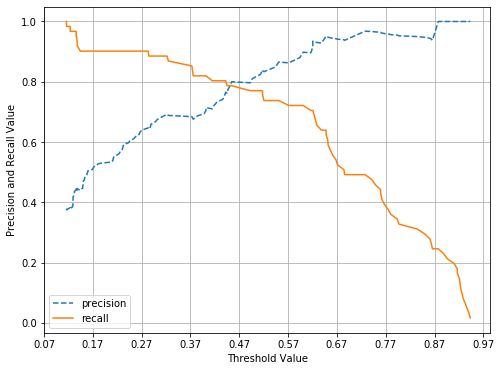

In [68]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

### 3.4. 정밀도와 재현율의 맹점
**Positive 예측의 임계값**을 변경하면 정밀도와 재현율의 수치도 변경되는 것을 알 수 있다. 정밀도와 재현율은 상호보완적인 수치이기에 하나의 성능 지표 수치를 올리기 위한 방법으로 쓰이면 안 된다. 즉, 재현율과 정밀도가 적절히 높을 때를 찾아야 한다.

#### 3.4.1. 정밀도가 100%가 되는 법
확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측     
**ex.** 환자 1000명 중 확실히 Positive 양성 반응인 환자는 단 1명
* `FP`=0, `TP`=1
* 정밀도 = `TP`/(`TP`+`FP`) = 1/(1+0) = 1(100%)

#### 3.4.2. 재현율이 100%가 되는 법
모두 Positive로 예측
**ex.** 환자 1000명 중 실제 Positive 양성 반응인 환자는 30명
* `FN`=0, `TP`=30
* 재현율 = `TP`/(`TP`+`FN`) = 30/(30+0) = 1(100%)

## 4. F1 스코어
F1 스코어(Score)는 정밀도와 재현율을 결합한 지표이다. 즉, **정밀도와 재현율 어느 한 쪽으로 치우치지 않을 때** 높은 값을 갖는다. `f1_score()` 메서드를 이용해 F1 스코어를 구할 수 있다.

$$F1 = \frac{2}{\frac{1}{recall}+\frac{1}{precision}} = 2*\frac{precision*recall}{precision+recall}$$

In [70]:
# 로지스틱 회귀 기반 타이타닉 생존자 모델의 F1 스코어
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print('F1 스코어 : {0:.4f}'.format(f1))

F1 스코어 : 0.7966


In [71]:
# 정확도, 정밀도, 재현율, F1 스코어, 오차 행렬을 계산하는 함수
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    print('오차 행렬 : ')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}'.format(accuracy, precision, recall, f1))

In [72]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값 :  0.4
오차 행렬 : 
[[97 21]
 [11 50]]
정확도 : 0.8212, 정밀도 : 0.7042, 재현율 : 0.8197, F1 : 0.7576

임계값 :  0.45
오차 행렬 : 
[[105  13]
 [ 13  48]]
정확도 : 0.8547, 정밀도 : 0.7869, 재현율 : 0.7869, F1 : 0.7869

임계값 :  0.5
오차 행렬 : 
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705, F1 : 0.7966

임계값 :  0.55
오차 행렬 : 
[[111   7]
 [ 16  45]]
정확도 : 0.8715, 정밀도 : 0.8654, 재현율 : 0.7377, F1 : 0.7965

임계값 :  0.6
오차 행렬 : 
[[113   5]
 [ 17  44]]
정확도 : 0.8771, 정밀도 : 0.8980, 재현율 : 0.7213, F1 : 0.8000



## 5. ROC 곡선과 AUC
ROC 곡선은 **FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)가 어떻게 변하는지**를 나타낸 곡선이다. 이 때 `x축`이 **FPR**이고, `y축`이 **TPR**이다.

### 5.1. TPR, TNR 과 FPR
* **TPR(True Positive Rate, 민감도, 재현율)** : 실제 Positive가 정확히 예측되어야 하는 수준
$$TPR = \frac{TP}{FN+TP}$$

* **TNR(True Negative Rate, 특이성)** : 실제 Negative가 정확히 예측되어야 하는 수준
$$TNR = \frac{TN}{FP+TN}$$

* **FPR(False Positive Rate)** : 실제 Negative가 잘못 예측되는 수준
$$FPR = 1-TNR = \frac{FP}{FP+TN}$$

### 5.2. 임계값과 FPR
**FPR**은 임계값(Positive 예측값을 결정하는 확률의 기준)으로 0부터 1까지 변경할 수 있다.
* 임계값을 1로 지정 → Positive 예측 기준이 매우 높음 → 대부분 Negative로 예측 → `FP`=0, `TN`=1 → **FPR=0**
* 임계값을 0으로 지정 → Positive 예측 기준이 매우 낮음 → 대부분 Positive로 예측 → `FP`=1, `TN`=0 → **FPR=1**

임계값을 1부터 0까지 변화시키면서 FPR을 구하고 FPR 값의 변화에 따라 TPR 값을 구하는 것이 ROC 곡선이다.

### 5.3. `roc_curve()`
`roc_curve(y_true, y_score)`를 이용하면 `FPR`, `TPR`, `Threshold`를 반환한다.
* `y_true` : 실제 클래스값 배열
* `y_score` : Positive 행의 예측 확률 배열 (=`predict_proba()`의 반환 배열의 두 번째 행)

In [77]:
# 타이타닉 생존자 예측 모델의 FPR, TPR, 임계값 구하기
from sklearn.metrics import roc_curve

# Positive(1)일 때의 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임계값 배열 행 47개 중 10개만 추출, 임계값을 5 step으로 추출
thr_idx = np.arange(0, thresholds.shape[0], 5)
print('sample 추출을 위한 임계값 배열의 idx 10개 : ', thr_idx)
print('sample 10개의 임계값 : ', np.round(thresholds[thr_idx], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR
print('sample 임계값별 FPR : ', np.round(fprs[thr_idx], 3))
print('sample 임계값별 TPR : ', np.round(tprs[thr_idx], 3))

sample 추출을 위한 임계값 배열의 idx 10개 :  [ 0  5 10 15 20 25 30 35 40 45]
sample 10개의 임계값 :  [1.94 0.87 0.63 0.55 0.44 0.32 0.15 0.14 0.13 0.12]
sample 임계값별 FPR :  [0.    0.008 0.025 0.059 0.127 0.203 0.559 0.602 0.695 0.847]
sample 임계값별 TPR :  [0.    0.246 0.672 0.738 0.787 0.885 0.902 0.951 0.967 0.984]


In [78]:
# roc 곡선 그래프
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    # ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    
    # 가운데 대각선 직선 (기준선)
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR x축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # x축, y축 이름 설정
    plt.xlabel('FPR(1 - TNR)')
    plt.ylabel('TPR(Recall)')
    
    # label 이름 표시
    plt.legend()

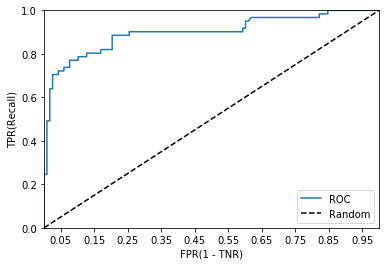

In [79]:
roc_curve_plot(y_test, pred_proba[:, 1])

### 5.4. AUC(Area Under Curve)
ROC 곡선은 **FPR과 TPR의 변화값을 보는데 이용**하며 실제 성능 지표로 사용되는 것은 **ROC 곡선 면적인 AUC**이다. AUC는 ROC 곡선 밑의 면적으로 1에 가까울수록 좋다.
* AUC의 값이 1에 가깝다.
* FPR이 작은 상태에서 큰 TPR을 얻는다.
* 가운데 기준선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 곡선에 이동한다.
* 직사각형에 가까운 곡선이 되어 면적이 1에 가까워진다.

`roc_auc_score()`를 이용하여 ROC곡선의 면적인 AUC를 구할 수 있다.

In [80]:
from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

ROC AUC 값 : 0.8429
